# Week 10 Workshop

We are continuing to work with the protein language model ESM-2. The model family is available on HuggingFace: https://huggingface.co/facebook/esm2_t12_35M_UR50D

We can access and use the model easily using the `transformers` library: https://huggingface.co/docs/transformers/en/index

As always, we begin by importing the required dependencies.

In [1]:
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchmetrics import Accuracy

from tqdm import tqdm
#import pandas as pd
import polars as pl
import numpy as np
import plotnine as pln

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from transformers import AutoTokenizer, EsmForMaskedLM, EsmForSequenceClassification


Next we're loading the tokenizer and models. We are loading two separate models, one to extract embeddings for logistic regression (as we have done before), and one for fine-tuning. We call the first model `model_embed` and the second simply `model`.

**Note:** If the following code runs extremely slowly or errors out you may have to update your python installation. Alternatively, you can try to run it in a python console, not in Jupyter. Older versions of Jupyter have a bug that prevents this code from running correctly.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_checkpoint = "facebook/esm2_t6_8M_UR50D"
# model_checkpoint = "facebook/esm2_t30_150M_UR50D" # requires more memory for finetuning but may converge faster

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model_embed = EsmForMaskedLM.from_pretrained(model_checkpoint)
model_embed.to(device)

# To train a model for classification/regression, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
# Use 1 if the problem is a regression, 2 or more if it is a classification.
num_labels = 2
model = EsmForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
model.to(device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

## Logistic regression using embeddings

Here we repeat the logistic regression using embeddings we have done previously. We do this purely so we have a comparison datapoint. We will subsequently do the same clasification with fine-tuning. Our dataset is again the β-lactamase data.

In [3]:
# read in data
data_complete = pl.read_csv('./data/B-Lactamase_Ranganathan2015.csv')

# add `activity` column with categories "high" and "low" depending on target threshold
# also add `label` column that is 1 for activity "high" and 0 otherwise
data_complete = data_complete.with_columns(
    pl.when(pl.col('target') > -1)
      .then(pl.lit('high'))
      .otherwise(pl.lit('low'))
      .alias('activity')
).with_columns(
    pl.when(pl.col('activity') == 'high')
      .then(pl.lit(1))
      .otherwise(pl.lit(0))
      .alias('label')
)

# optionally down-sample data
target_fract = 1
data = data_complete.sample(fraction = target_fract, seed=8592153)
data


ID,mutant,target,sequence,wt,site,mut,activity,label
str,str,f64,str,str,i64,str,str,i32
"""BLAT_Ran_H24C""","""H24C""",-0.41826,"""MSIQHFRVALIPFFAAFCLPVFACPETLVK…","""H""",24,"""C""","""high""",1
"""BLAT_Ran_H24E""","""H24E""",-0.279024,"""MSIQHFRVALIPFFAAFCLPVFAEPETLVK…","""H""",24,"""E""","""high""",1
"""BLAT_Ran_H24D""","""H24D""",-0.181607,"""MSIQHFRVALIPFFAAFCLPVFADPETLVK…","""H""",24,"""D""","""high""",1
"""BLAT_Ran_H24G""","""H24G""",-0.060242,"""MSIQHFRVALIPFFAAFCLPVFAGPETLVK…","""H""",24,"""G""","""high""",1
"""BLAT_Ran_H24F""","""H24F""",-0.818487,"""MSIQHFRVALIPFFAAFCLPVFAFPETLVK…","""H""",24,"""F""","""high""",1
…,…,…,…,…,…,…,…,…
"""BLAT_Ran_W286S""","""W286S""",-2.967712,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""S""","""low""",0
"""BLAT_Ran_W286R""","""W286R""",-2.707731,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""R""","""low""",0
"""BLAT_Ran_W286T""","""W286T""",-2.806422,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""T""","""low""",0


Now we calculate embeddings, perform a PCA, and do a logistic regression on the first 20 components. The first code block proceeds through the PCA.

In [4]:
mean_representations = {}
with torch.no_grad():  # disable gradient calculations
    for seq_id, sequence in tqdm( # iterate using a nice progress bar
        data.select(['ID', 'sequence']).iter_rows(), 
        desc = "Processing sequences", 
        leave = False,
        total = len(data)
    ):
        # tokenize without padding or truncation
        tokens = tokenizer(sequence, return_tensors = "pt", padding = False, truncation = False)
        tokens = tokens.to(device)
        
        # get model output (hidden states are the embedding layers)
        output = model_embed(tokens['input_ids'], output_hidden_states = True)
 
        # get the last hidden state
        # (Not the most efficient for larger datasets. For larger we should use batches.)
        embeddings = output.hidden_states[-1][0]  # Last layer, first and only sequence (batch size = 1)

        # extract the mean embeddings for the sequence, excluding [CLS] and [EOS]
        representations = embeddings[1:-1, :].detach().cpu()  
        
        # compute mean representation of the sequence
        mean_representations[seq_id] = representations.mean(dim=0)

# join emeddings and original data frame
embed = pl.DataFrame(mean_representations).transpose(include_header=True, header_name='ID')
embed_df = data.join(embed, on='ID')

# we can extract the embedding dimension from one of the calculated embeddings
embed_dim = list(mean_representations.values())[0].numpy().shape[0]

# select only the embedding columns
features = embed_df.select(pl.col([f'column_{str(i)}' for i in range(embed_dim)]))

# run PCA and extract 20 components
n_components = 20
X_pca  = PCA(n_components=n_components).fit_transform(features)


Next we define a function that calculates training and test accuracies, and for the test data also calculates a confusion matrix and plots it. We will use this function later on for the fine-tuned model also.

In [5]:
def summarize_classifier_performance(y_train, y_train_pred, y_test, y_test_pred):
    # evaluate performance
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print("CLASSIFICATION RESULTS")
    print(f"{'='*45}")
    print(f"Training Accuracy: {train_accuracy:.2%}")
    print(f"Test Accuracy: {test_accuracy:.2%}\n")

    print("Test Set Confusion Matrix:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"                  Predicted")
    print(f"               high       low")
    print(f"Actual high    {cm[1,1]:3d}        {cm[1,0]:3d}")
    print(f"       low     {cm[0,1]:3d}        {cm[0,0]:3d}")
    
    # create confusion matrix visualization
    cm_df = pl.DataFrame({
        'actual': ['low', 'low', 'high', 'high'],
        'predicted': ['low', 'high', 'low', 'high'],
        'count': [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
    })
    
    cm_plot = (
        pln.ggplot(cm_df, pln.aes(x = 'predicted', y = 'actual', fill = 'count'))
        + pln.geom_tile(color = 'white', size = 1.5)
        + pln.geom_text(pln.aes(label = 'count'), size = 20, color = 'white')
        + pln.scale_fill_gradient(low = '#3498db', high = '#e74c3c')
        + pln.scale_x_discrete(limits = ['high', 'low'])
        + pln.scale_y_discrete(limits = ['low', 'high'])
        + pln.labs(
            x='Predicted',
            y='Actual',
            fill='Count'
        )
        + pln.theme_minimal()
        + pln.theme(
            figure_size = (5, 3.5)
        )
    )
    
    return cm_plot


The next code block performs the actual logistic regression.

CLASSIFICATION RESULTS
Training Accuracy: 61.61%
Test Accuracy: 61.50%

Test Set Confusion Matrix:
                  Predicted
               high       low
Actual high    269        214
       low     171        346


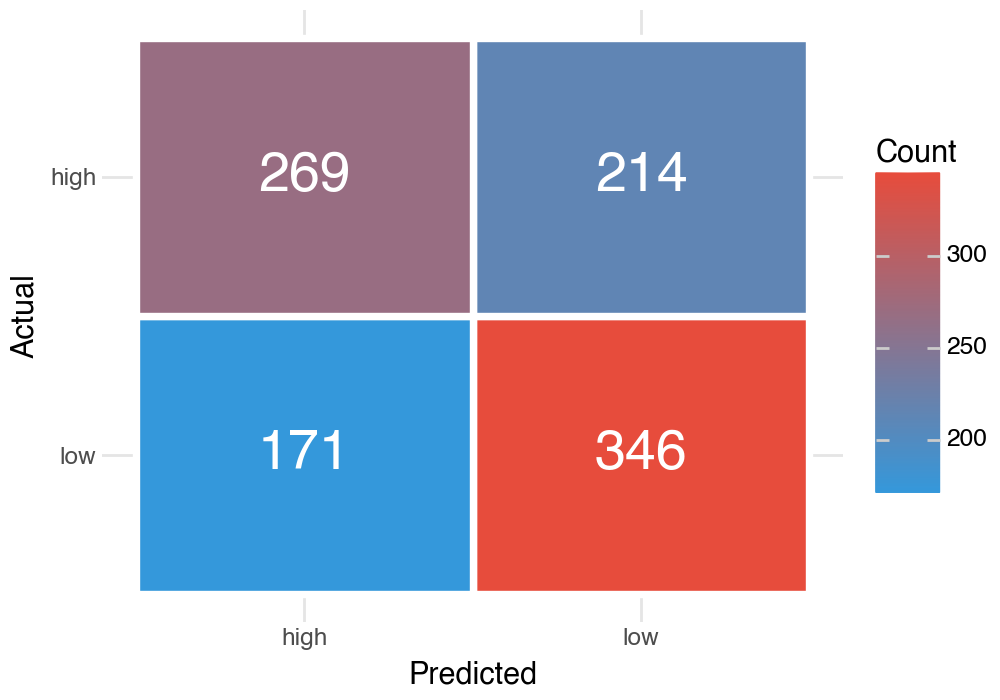

In [6]:
# the label column is our numeric response variable
y = embed_df['label']

# create the training/test split
random_state = 16492345 # change for different train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size = 0.2, random_state = random_state, stratify = y
)
    
# train logistic regression classifier on PCA components
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)
    
# make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

cm_plot = summarize_classifier_performance(y_train, y_train_pred, y_test, y_test_pred)
cm_plot.show()

## Prediction via fine-tuning of classification head

Next we perform the same classification but now we are fine-tuning the model.

In [7]:
# split the data as before
random_state = 16492345 # use same random seed as above for comparison
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=random_state, stratify = data['label']
)

# verify the split is the same as used for logistic regression
print(
    f"Percent of identical training labels: {100*sum(y_train == train_data['label'])/len(y_train)}"
)
print(
    f"Percent of identical test labels: {100*sum(y_test == test_data['label'])/len(y_test)}"
)

Percent of identical training labels: 100.0
Percent of identical test labels: 100.0


For model fine-tuning, we may want to freeze some layers. We may also want to add drop-out. First the code for layer freezing. We start with some helper functions.

In [8]:
def freeze_layers(model, n_layers: int=1):
    '''Freezes all transformer layers and then unfreezes the last `n_layers` layers.'''
    # freeze embedding weights
    for param in model.esm.embeddings.parameters():
        param.requires_grad = False
        
    # freeze all encoder layers
    for param in model.esm.encoder.parameters():
        param.requires_grad = False

    # unfreeze last `n_layers` layers
    for layer in model.esm.encoder.layer[-n_layers:]:
       for param in layer.parameters():
           param.requires_grad = True

    # print trainable parameters (for verification)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Trainable: {name}")
    
def count_params(model):
    '''Count the number of trainable and non-trainable parameters in a model.'''
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")

Next we freeze all but the last layer.

In [9]:
print("Model status before freezing:")
count_params(model)
print()
freeze_layers(model, 1)
print("\nModel status after freezing:")
count_params(model)

Model status before freezing:
Total parameters: 7,512,443
Trainable parameters: 7,512,443
Frozen parameters: 0

Trainable: esm.encoder.layer.5.attention.self.query.weight
Trainable: esm.encoder.layer.5.attention.self.query.bias
Trainable: esm.encoder.layer.5.attention.self.key.weight
Trainable: esm.encoder.layer.5.attention.self.key.bias
Trainable: esm.encoder.layer.5.attention.self.value.weight
Trainable: esm.encoder.layer.5.attention.self.value.bias
Trainable: esm.encoder.layer.5.attention.output.dense.weight
Trainable: esm.encoder.layer.5.attention.output.dense.bias
Trainable: esm.encoder.layer.5.attention.LayerNorm.weight
Trainable: esm.encoder.layer.5.attention.LayerNorm.bias
Trainable: esm.encoder.layer.5.intermediate.dense.weight
Trainable: esm.encoder.layer.5.intermediate.dense.bias
Trainable: esm.encoder.layer.5.output.dense.weight
Trainable: esm.encoder.layer.5.output.dense.bias
Trainable: esm.encoder.layer.5.LayerNorm.weight
Trainable: esm.encoder.layer.5.LayerNorm.bias
Trai

When we inspect the classification head, we see that the dropout is set to zero. We can change it to the desired value.

In [10]:
model.classifier

EsmClassificationHead(
  (dense): Linear(in_features=320, out_features=320, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (out_proj): Linear(in_features=320, out_features=2, bias=True)
)

In [11]:
# set dropout
model.classifier.dropout.p = 0.2
# inspect classification head again
model.classifier

EsmClassificationHead(
  (dense): Linear(in_features=320, out_features=320, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out_proj): Linear(in_features=320, out_features=2, bias=True)
)

Next we need code for data loading and training.

In [12]:
# helper class to return individual sequences and associated labels from the data
class SequenceDataset(Dataset):
    def __init__(self, data):
        self.sequences = data['sequence'].to_list()
        self.labels = torch.tensor(data['label'].to_list(), dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {'sequence': self.sequences[idx], 'labels': self.labels[idx]}

# function that combines individual items into batches
def collate_fn(batch):
    sequences = [item['sequence'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    encodings = tokenizer(sequences, padding=True, truncation=True, max_length=1022, return_tensors='pt')
    encodings['labels'] = labels
    return encodings


We encapsulate the entire training loop in a function. We could alternatively use the HuggingFace `Trainer` API (see [here](https://huggingface.co/learn/llm-course/en/chapter3/3) for a tutorial) but it is instructive to write the loop ourselves to see exactly what is happening step-by-step.

In [ ]:
def train(model, train_loader, eval_loader, device, learning_rate, epochs,
          save_best_model = False, train_name = "esm-finetuned"):
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # metrics
    train_accuracy = Accuracy(task="binary", num_classes=num_labels).to(device)
    eval_accuracy = Accuracy(task="binary", num_classes=num_labels).to(device)

    # dataframe to store metrics as they are generated during training
    metrics = pl.DataFrame(schema = {
        "epoch": pl.Int64,
        "data": pl.Utf8,
        "loss": pl.Float64,
        "accuracy": pl.Float64,
    })

    max_eval_acc = 0 # keep track of best accuracy so far

    # Trainer
    for epoch in range(epochs):
        model.train()
        train_loss = []
    
        # Training loop
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
        for step, batch in enumerate(train_pbar):
            optimizer.zero_grad() # this is fundamntal to to accumulate gradients between epoch, unless we want to.

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
            # Calculate training accuracy and loss
            loss = outputs.loss
            train_loss.append(loss.item())
            preds = torch.argmax(outputs.logits, dim=1)

            # Update metrics
            train_accuracy.update(preds, labels)
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{train_accuracy.compute().item():.4f}'})
        
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # train metrics
        epoch_train_loss = np.mean(train_loss)
        epoch_train_accuracy = train_accuracy.compute()
        train_accuracy.reset()
    
    
        # Evaluation loop
        model.eval()
        eval_loss = []
        eval_pbar = tqdm(eval_loader, desc=f"Epoch {epoch + 1}/{epochs} [Eval]", leave=False)
        with torch.no_grad():
            for batch in eval_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
            
                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
                # Calculate evaluation accuracy and loss
                loss = outputs.loss
                eval_loss.append(loss.item())
                preds = torch.argmax(outputs.logits, dim=1)

                # Update metrics
                eval_accuracy.update(preds, labels)
                eval_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{eval_accuracy.compute().item():.4f}'})
            
    
        # Eval metrics
        epoch_eval_accuracy = eval_accuracy.compute()
        epoch_eval_loss = np.mean(eval_loss)
        eval_accuracy.reset()

        # create dataframe row of metrics for this epoch
        epoch_metrics = pl.DataFrame({
            "epoch": [epoch + 1, epoch + 1],
            "data": ['train', 'test'],
            "loss": [epoch_train_loss, epoch_eval_loss],
            "accuracy": [epoch_train_accuracy, epoch_eval_accuracy],
        })

        # add new metrics to metrics dataframe
        metrics = pl.concat([metrics, epoch_metrics], how="vertical")

        # update best eval accuracy and save model if requested
        if epoch_eval_accuracy > max_eval_acc:
            max_eval_acc = epoch_eval_accuracy
            if save_best_model:
                # save the model
                torch.save(model.state_dict(), "./data/" + train_name + ".pt")
                print(f"Epoch: {epoch + 1}, eval acc: {epoch_eval_accuracy}, saving model to {"./data/" + train_name + ".pt"}")
    
    return metrics

Now we can create the data loaders that we need for model training.

In [17]:
batch_size = 32

# convert dataframe to Dataset objects
train_dataset = SequenceDataset(train_data)
eval_dataset = SequenceDataset(test_data)

# create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, collate_fn=collate_fn)

Finally we are ready for the actual training. It can take several hours, so here in this notebook training is turned off by default and instead in the next section we're loading in the fine-tuned model and training history from disk.

**Note:** Smaller models are easy to fit into small GPUs, however they take longer to converge.
If you are in a rush, and have a bigger GPU, try training the ESM2 150M model, it can converge within 10 epochs with a larger learning rate, maybe 5 times larger.

In [18]:
train_model = True
save_train_results = True
train_name = "ESM2_8M_finetune"
epochs = 140
learning_rate = 1e-4

if train_model:
    metrics = train(
        model, train_loader, eval_loader, device, learning_rate, epochs,
        save_best_model = save_train_results, train_name = train_name
    )

    # save the history from the training run if we're saving results
    if save_train_results:
        metrics.write_csv("./data/" + train_name + "_history.csv")

Epoch 1/140 [Train]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 1, saving model to ./data/ESM2_8M_finetune.pt


KeyboardInterrupt: 

## Model performance of fine-tuned model

In [ ]:
# Load the DataFrame back from the CSV file
metrics = pl.read_csv("./data/" + train_name + "_history.csv")

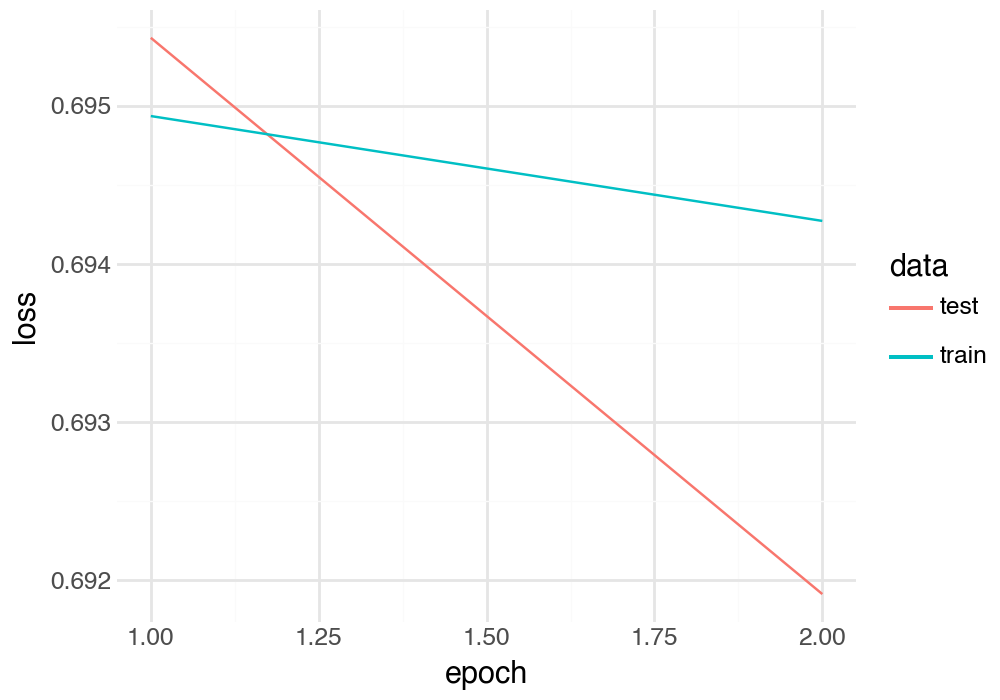

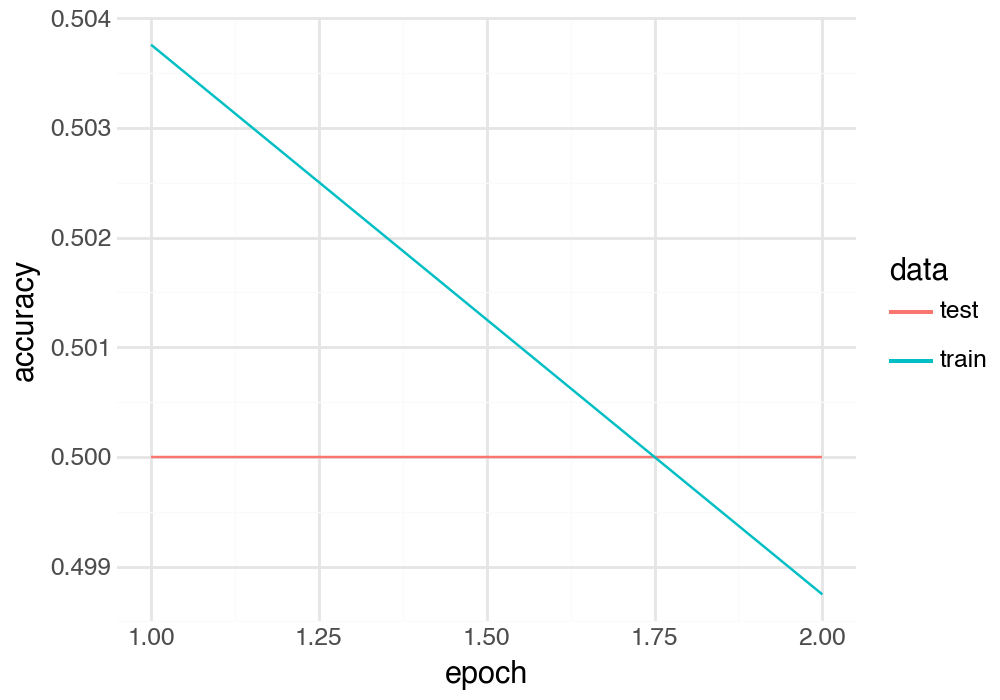

In [ ]:
loss_plot = (
    pln.ggplot(metrics, pln.aes(x = 'epoch', y = 'loss', color = 'data'))
    + pln.geom_line()
    + pln.theme_minimal()
    + pln.theme(
        figure_size = (5, 3.5)
    )
)
loss_plot.show()

acc_plot = (
    pln.ggplot(metrics, pln.aes(x = 'epoch', y = 'accuracy', color = 'data'))
    + pln.geom_line()
    + pln.theme_minimal()
    + pln.theme(
        figure_size = (5, 3.5)
    )
)
acc_plot.show()

In [ ]:
# load the saved model weights
model.load_state_dict(torch.load(
    "./data/" + train_name + ".pt",
    weights_only = True,
    map_location = device
))

# put the model into evaluation mode
model.eval()

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

Calculate model predictions once more on training and test data.

In [ ]:
def model_predictions(batch_loader):
    y = []
    y_pred = []

    with torch.no_grad():
        for batch in batch_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
            # Calculate prediction and append to result vectors
            preds = torch.argmax(outputs.logits, dim=1)
            y.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    return y, y_pred

y_train, y_train_pred = model_predictions(
    tqdm(train_loader, desc="Training data", leave=False)
)
y_test, y_test_pred = model_predictions(
    tqdm(eval_loader, desc="Test data", leave=False)
)


CLASSIFICATION RESULTS
Training Accuracy: 49.62%
Test Accuracy: 50.00%

Test Set Confusion Matrix:
                  Predicted
               high       low
Actual high      0         50
       low       0         50


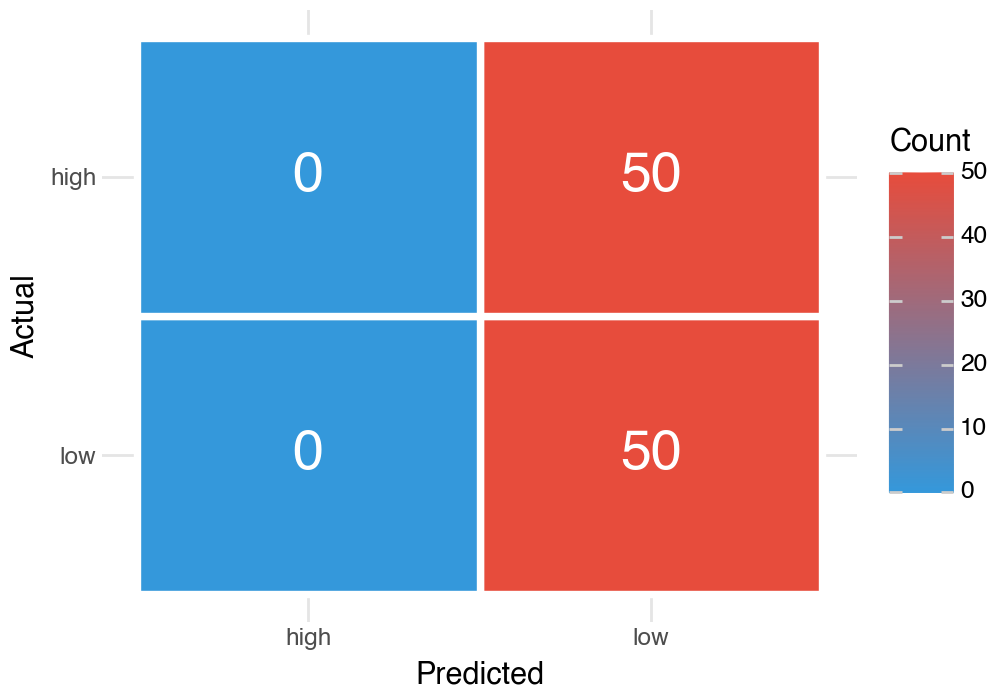

In [ ]:
cm_plot = summarize_classifier_performance(y_train, y_train_pred, y_test, y_test_pred)
cm_plot.show()

## Excercises

- Run the logistic regression with the 150M parameter model and see what performance you get. Compare to the results from the 8M parameter finetuned model.
- Try a fine-tuning training run on your laptop, just to see how long it takes. (You may want to turn off model saving so you don't overwrite the trained model I provide.)